In [1]:
import argparse
from itertools import product as iterprod
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from argparse import ArgumentParser
import time
from datetime import datetime
from tqdm.autonotebook import tqdm

import matplotlib.pyplot as plt



/tmp/ipykernel_44328/33645171.py:12: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
import utils.data_processing as dp
from utils.UNeXt import UNet
from utils.loss import loss_function_dict

import utils.nb_utils as nb_utils

import pprint

np.random.seed(11) # for reproducibility
torch.manual_seed(11)


%load_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
batch_size = 8
num_workers = 4

# Device
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
pin_memory = True if torch.cuda.is_available() else False

# Build dataset

In [4]:
# Dataset
directory  = './data/ZyxAct_16kPa_small/'
test_cells = 'cell_1'


in_channels  = [[6,7]] # Example: [[4], [4,6], [4,6,7]]. Channel 4 is mask, 6 is zyxin, 7 is other protein (here actin)
out_channels = (2,3)
transform_kwargs = {'crop_size': 512,
                    'output_channels': out_channels, 
                    'vector_components': [out_channels, (0,1)],
                    'magnitude_only': False,
                    'angmag': True,
                    'norm_output': {'rescale': 0.25, 'threshold': 0.4},
                    }

dataset_kwargs = { 
                    'root': directory,
                    'force_load': False,
                    'test_split': 'bycell',
                    'test_cells': test_cells,
                    'in_channels': in_channels, 
                    'out_channels': out_channels, 
                    'transform_kwargs': transform_kwargs,
                    'frames_to_keep': 256,
                    'input_baseline_normalization': 'outside_inside', # Comment on what these do
                    'output_baseline_normalization': 'mean_dataset',
                    'remake_dataset_csv': True,
                    'exclude_frames': [31,90]
                     }


dataset = dp.CellDataset( **dataset_kwargs )

train_loader = dataset.get_loader(dataset.train_indices, batch_size, num_workers, pin_memory)
validation_loader = dataset.get_loader(dataset.test_indices, batch_size, num_workers, pin_memory)

In [5]:
dataset

# Some visualizations of the training data

The dataset class gets items by looking into a dataframe (`dataset.info`) where the folders and filenames are stored. Folders correspond to single cells, and each file is a frame of the time series. 

`dataset.info` contains the normalization values which the data is normalized by before it is passed to the NN. Forces are normalized by `dataset.info.F_mean` and the zyxin signal is normalized by `dataset.info.zyxin_baseline_out` and `dataset.info.zyxin_baseline_in`. Details about how these are generated can be found in the DataProcessing notebook.
    


In [6]:
df = dataset.info.copy()

df.head(10)

,index,folder,filename,frame,root,zyxin_baseline,actin_baseline,zyxin_baseline_out,zyxin_baseline_in,actin_baseline_out,actin_baseline_in,F_mean,F_max
0,0,cell_0,Disp_Trac_CellMask_ForceMask_Actin_0.npy,0,./data/ZyxAct_16kPa_small/,0.0,0.0,5.212261,129.156811,76.050815,509.421164,205.322983,3474.241516
1,1,cell_0,Disp_Trac_CellMask_ForceMask_Actin_1.npy,1,./data/ZyxAct_16kPa_small/,0.0,0.0,5.212261,129.156811,76.050815,509.421164,205.322983,3474.241516
2,2,cell_0,Disp_Trac_CellMask_ForceMask_Actin_2.npy,2,./data/ZyxAct_16kPa_small/,0.0,0.0,5.212261,129.156811,76.050815,509.421164,205.322983,3474.241516
3,3,cell_0,Disp_Trac_CellMask_ForceMask_Actin_3.npy,3,./data/ZyxAct_16kPa_small/,0.0,0.0,5.212261,129.156811,76.050815,509.421164,205.322983,3474.241516
4,4,cell_0,Disp_Trac_CellMask_ForceMask_Actin_4.npy,4,./data/ZyxAct_16kPa_small/,0.0,0.0,5.212261,129.156811,76.050815,509.421164,205.322983,3474.241516
5,5,cell_0,Disp_Trac_CellMask_ForceMask_Actin_5.npy,5,./data/ZyxAct_16kPa_small/,0.0,0.0,5.212261,129.156811,76.050815,509.421164,205.322983,3474.241516
6,6,cell_0,Disp_Trac_CellMask_ForceMask_Actin_6.npy,6,./data/ZyxAct_16kPa_small/,0.0,0.0,5.212261,129.156811,76.050815,509.421164,205.322983,3474.241516
7,7,cell_0,Disp_Trac_CellMask_ForceMask_Actin_7.npy,7,./data/ZyxAct_16kPa_small/,0.0,0.0,5.212261,129.156811,76.050815,509.421164,205.322983,3474.241516
8,8,cell_0,Disp_Trac_CellMask_ForceMask_Actin_8.npy,8,./data/ZyxAct_16kPa_small/,0.0,0.0,5.212261,129.156811,76.050815,509.421164,205.322983,3474.241516
9,9,cell_0,Disp_Trac_CellMask_ForceMask_Actin_9.npy,9,./data/ZyxAct_16kPa_small/,0.0,0.0,5.212261,129.156811,76.050815,509.421164,205.322983,3474.241516


In [7]:
# Print test cells: 
print(dataset.test_cells)
print(dataset.test_indices)

{'test_cells': ['cell_1']}
[198 195 209 191 230 225 202 220 242 221 205 213 241 222 223 210 200 201
 219 187 215 228 196 186 214 235 188 229 237 189 204 192 243 224 203 233
 194 212 207 206 227 238 193 226 216 218 211 234 185 232 197]


In [8]:
cell = 'cell_1'
frame = 5

idx = dataset.info.index[(dataset.info.folder==cell)&(dataset.info.frame==frame)].tolist()[0] # Get index in dataframe that contains the right cell and frame.
print(idx)

188


In [9]:
dataset.out_channels


(2, 3)

In [10]:
sample = dataset[idx]

{'mask': torch.Size([1, 512, 512]), 'zyxin': torch.Size([1, 512, 512]), 'actin': torch.Size([1, 512, 512]), 'output': torch.Size([2, 512, 512]), 'displacements': torch.Size([2, 512, 512])}


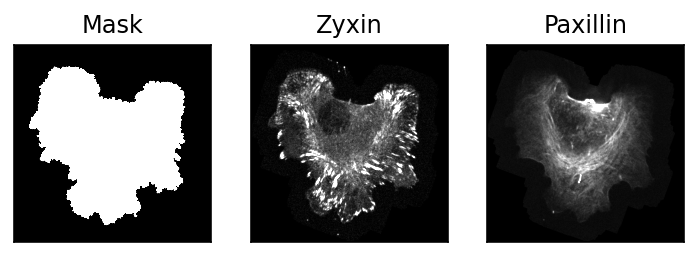

In [11]:
fig,ax=plt.subplots(1,3,figsize=(2*3, 4*2), dpi=144)


print({key: sample[key].shape for key in sample.keys()})

ax[0].set_title('Mask')
ax[0].imshow(sample['mask'].squeeze(), origin='lower', cmap='gray', vmax=1, vmin=0)
ax[1].set_title('Zyxin')
ax[1].imshow(sample['zyxin'].squeeze(), origin='lower', cmap='gray', vmax=3, vmin=0)
ax[2].set_title('Paxillin')
ax[2].imshow(sample['output'][0,:,:].squeeze(), origin='lower', cmap='gray', vmax=20, vmin=0)


for a in ax.flat:
    a.set_xticks([])
    a.set_yticks([])

In [12]:
sample

{'mask': tensor([[[0., 0., -0.,  ..., -0., -0., -0.],
          [-0., 0., 0.,  ..., 0., 0., -0.],
          [-0., 0., 0.,  ..., -0., -0., 0.],
          ...,
          [0., 0., -0.,  ..., 0., 0., -0.],
          [-0., -0., 0.,  ..., 0., 0., -0.],
          [-0., 0., -0.,  ..., 0., -0., 0.]]]),
 'zyxin': tensor([[[0., 0., -0.,  ..., -0., 0., -0.],
          [-0., 0., 0.,  ..., -0., 0., 0.],
          [0., 0., -0.,  ..., 0., -0., -0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., -0.],
          [-0., -0., 0.,  ..., 0., 0., -0.],
          [-0., 0., -0.,  ..., 0., -0., 0.]]]),
 'actin': tensor([[[-0., 0., -0.,  ..., -0., -0., -0.],
          [0., -0., -0.,  ..., 0., 0., -0.],
          [-0., -0., 0.,  ..., -0., -0., 0.],
          ...,
          [0., 0., -0.,  ..., 0., 0., -0.],
          [-0., -0., 0.,  ..., 0., 0., -0.],
          [-0., 0., -0.,  ..., 0., -0., 0.]]]),
 'output': tensor([[[-0., 0., -0.,  ..., -0., -0., -0.],
          [0., -0., -0.,  ..., 0., 0., -0.],
          

# Build U-Net model with ConvNext blocks

In [13]:
n_lyr  = 3 # number of downsampling layers
ds_krnl= 4 # downsample kernel
n_ch   = 4 # number of channels in the beginning of the network
n_blocks = 4 # number of ConvNext blocks, wherever ConvNext blocks are used

prepend_hparams = {'start_channel': 1, 'resnet_channel': n_ch, 'end_channel': n_ch, 'N_blocks': n_blocks,                                         # Args for architecture
                    'kernel': 7,'stride': 1, 'inv_bottleneck_factor': 4, 'dilation': 1,'dropout_rate': 0.1, 'activation': 'gelu', 'batchnorm': 1} # Args for ConvNext blocks
encoder_hparams = {'n_ch': n_ch, 'n_layers': n_lyr, 'N_node_blocks': n_blocks, 'N_skip_blocks': n_blocks,
                    'downsample_kwargs': {'kernel': ds_krnl, 'activation': 'gelu', 'batchnorm': 1},
                    'interlayer_kwargs': {'kernel': 7,'stride': 1, 'inv_bottleneck_factor': 4, 'dilation': 1,'dropout_rate': 0.1, 'activation': 'gelu', 'batchnorm': 1}
                    }
decoder_hparams = {'n_layers': n_lyr, 'N_node_blocks': n_blocks, 'upsample_kernel': ds_krnl,
                    'kernel': 7,'stride': 1, 'inv_bottleneck_factor': 4, 'dilation': 1,'dropout_rate': 0.1, 'activation': 'gelu', 'batchnorm': 1}
append_hparams = {'start_channel': n_ch, 'resnet_channel': n_ch, 'end_channel': 2, 'N_blocks': n_blocks,
                    'kernel': 7,'stride': 1, 'inv_bottleneck_factor': 8, 'dilation': 1,'dropout_rate': 0.1, 'activation': 'gelu', 'batchnorm': 1} 
optimizer_hparams = {'LR': 0.001, 'schedule_rate': 0.99}
loss_hparams = {'loss_type': 'am',
                'exp_weight': 0.0,
                'strainenergy_regularization': 0.0,
                'exp_schedule': {'type': 'linear', 'width': 310, 'e_crit': 30},
                'reg_schedule': {'type': 'linear', 'width': 310, 'e_crit': 30},
                'loss_kwargs': {'max_force': 8.}
               }





models = {}
for protein in ['zyxin1','zyxin2']:
    modelname = 'model_6to7_50ep'

    logger_params = {'log_dir': f'./tensorboard_logs/{modelname}', 
                     'image_epoch_freq': 10,
                     'image_callbacks': 'vectorfield,hists',
                     'save_model_freq': 4}

    # Actually build model:
    model_kwargs={
                    'input_type':  protein[:-1], 
                    'prepend_hparams': prepend_hparams, 
                    'encoder_hparams': encoder_hparams, 
                    'decoder_hparams': decoder_hparams, 
                    'append_hparams': append_hparams, 
                    'optimizer_hparams': optimizer_hparams,
                    'loss_hparams': loss_hparams,
                    'logger_params': logger_params,
                    'name': 'model_0'}


    model = UNet( **model_kwargs, model_idx=0)
    model.to(device)
    
    models[protein] = model


LOSS KWARGS {'loss_type': 'am', 'exp_weight': 0.0, 'strainenergy_regularization': 0.0, 'exp_schedule': {'type': 'linear', 'width': 310, 'e_crit': 30}, 'reg_schedule': {'type': 'linear', 'width': 310, 'e_crit': 30}, 'loss_kwargs': {'max_force': 8.0}}
LOSS KWARGS {'loss_type': 'am', 'exp_weight': 0.0, 'strainenergy_regularization': 0.0, 'exp_schedule': {'type': 'linear', 'width': 310, 'e_crit': 30}, 'reg_schedule': {'type': 'linear', 'width': 310, 'e_crit': 30}, 'loss_kwargs': {'max_force': 8.0}}


In [14]:
models

{'zyxin1': UNet(
   (layers_encode): ModuleList(
     (0): ModuleList(
       (0-3): 4 x ConvNextCell(
         (conv0): Conv2d(4, 4, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=4)
         (conv1): Conv2d(4, 16, kernel_size=(1, 1), stride=(1, 1))
         (conv2): Conv2d(16, 4, kernel_size=(1, 1), stride=(1, 1))
         (bn): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
         (act): GELU(approximate='none')
       )
       (4): DownsampleLayer(
         (conv): Conv2d(4, 8, kernel_size=(4, 4), stride=(4, 4))
         (bn): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
         (act): GELU(approximate='none')
       )
     )
     (1): ModuleList(
       (0-3): 4 x ConvNextCell(
         (conv0): Conv2d(8, 8, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=8)
         (conv1): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
         (conv2): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
  

In [15]:
protein[:-1]

'zyxin'

# Perform training

In [16]:
save_models = True
n_epochs = 100

# pbar = tqdm(total=n_epochs*(np.minimum(dataset.frames_to_keep, len(dataset.train_indices))/batch_size))

# t0 = time.time()
# for e in range(n_epochs):
#     pbar.set_description(f'Epoch {e}')
#     loss_values_train = {}
#     loss_values_val = {}

#     for mkey in models.keys():
#         models[mkey].reset_running_train_loss()
#         models[mkey].reset_running_val_loss()

#     for sample in train_loader: 
#         for key in sample:
#             sample[key] = sample[key].to(device)
        
#         for mkey in models.keys():
#             models[mkey].training_step(sample, epoch=e) # loss.backward() and optimizer step occur in here
        
#         pbar.update(1)

#     for sample in validation_loader:
#         for key in sample:
#             sample[key] = sample[key].to(device)
    
#         for mkey in models.keys():
#             models[mkey].validation_step(sample, epoch=e)

#     for mkey in models.keys():
#         models[mkey].scheduler.step()

#     print("Epoch %u:\t Time: %0.2f \t(per epoch: %0.2f)"%(e, time.time()-t0, (time.time()-t0)/(e+1)))

#     # SAVE
#     if save_models:
#         # Log in tensorboard
#         # for mkey in models.keys():
#         #     model[mkey].log_images(epoch=e)
#         #     model[mkey].log_scalars(epoch=e) 
            
#         # Save models
#         if e%(logger_params['save_model_freq'])==0 or e==n_epochs-1: 
#             torch.save({'model': model.state_dict(),
#                         'model_kwargs': model_kwargs,
#                         'model_name': model.name,
#                         'model_idx': model.index,
#                         'dataset_kwargs': dataset_kwargs,
#                         'test_cells': dataset.test_cells,
#                         }, 
#                        os.path.join( model.logdir, 'model.pt') )


  0%|          | 0/2287.5 [00:00<?, ?it/s]

Epoch 0:	 Time: 178.97 	(per epoch: 178.97)
Epoch 1:	 Time: 340.50 	(per epoch: 170.25)
Epoch 2:	 Time: 501.88 	(per epoch: 167.29)
Epoch 3:	 Time: 663.56 	(per epoch: 165.89)
Epoch 4:	 Time: 824.27 	(per epoch: 164.85)
Epoch 5:	 Time: 985.73 	(per epoch: 164.29)
Epoch 6:	 Time: 1146.82 	(per epoch: 163.83)
Epoch 7:	 Time: 1308.26 	(per epoch: 163.53)
Epoch 8:	 Time: 1469.41 	(per epoch: 163.27)
Epoch 9:	 Time: 1630.02 	(per epoch: 163.00)
Epoch 10:	 Time: 1792.47 	(per epoch: 162.95)
Epoch 11:	 Time: 1953.31 	(per epoch: 162.78)
Epoch 12:	 Time: 2114.12 	(per epoch: 162.62)
Epoch 13:	 Time: 2275.34 	(per epoch: 162.52)
Epoch 14:	 Time: 2436.97 	(per epoch: 162.46)
Epoch 15:	 Time: 2598.12 	(per epoch: 162.38)
Epoch 16:	 Time: 2758.90 	(per epoch: 162.29)
Epoch 17:	 Time: 2920.27 	(per epoch: 162.24)
Epoch 18:	 Time: 3081.46 	(per epoch: 162.18)
Epoch 19:	 Time: 3242.73 	(per epoch: 162.14)
Epoch 20:	 Time: 3403.72 	(per epoch: 162.08)
Epoch 21:	 Time: 3565.11 	(per epoch: 162.05)
Epoc

In [ ]:
models.load_state_dict(torch.load(model.logdir, 'model.pt'))
# models.eval()

# Plot prediction on train cell

In [ ]:
fig,ax=plt.subplots(1,3,figsize=(3*3, 3*1), dpi=200)

model = models['actin']

eval_dataset_kwargs = dataset_kwargs
eval_dataset_kwargs['transform_kwargs']['crop_size'] = 960
eval_dataset_kwargs['exclude_frames'] = None
dataset_eval = dp.CellDataset( **eval_dataset_kwargs )

cell = 'cell_3'
frame = 0

idx = dataset_eval.info.index[(dataset_eval.info.folder==cell)&(dataset_eval.info.frame==frame)].tolist()[0] # Get index in dataframe that contains the right cell and frame.


sample = dataset_eval[idx] # get item

input_image = model.select_inputs(model.input_type, sample).unsqueeze(0).to(device)
print(input_image.shape)

pred = model(input_image).detach().cpu().numpy()

print(pred.shape)

ax[0].set_title('Zyxin')
ax[0].imshow(sample['zyxin'].squeeze(), origin='lower', cmap='gray', vmax=3, vmin=0)

ax[1].set_title('$\\vec{F}_{exp}$')
ax[1].imshow(sample['output'].squeeze()[0], origin='lower', cmap='inferno', vmax=4, vmin=0)
ax[1].quiver(*nb_utils.make_vector_field(*sample['output'].squeeze(), downsample=20, threshold=0.4, angmag=True), color='w', scale=20, width=0.003)

ax[2].set_title('$\\vec{F}_{NN}$')
ax[2].imshow(pred.squeeze()[0], origin='lower', cmap='inferno', vmax=4, vmin=0)
ax[2].quiver(*nb_utils.make_vector_field(*pred.squeeze(), downsample=20, threshold=0.4, angmag=True), color='w', scale=20, width=0.003)

for a in ax.flat:
    a.set_xticks([])
    a.set_yticks([])

# Performance on test cell
## It seems to underpredict quite dramatically, but we don't necessarily expect great generalization because the network was trained on an extremely small dataset (~180 frames).

In [ ]:
fig,ax=plt.subplots(1,3,figsize=(3*3, 3*1), dpi=200)

model = models['actin']

eval_dataset_kwargs = dataset_kwargs
eval_dataset_kwargs['transform_kwargs']['crop_size'] = 960
eval_dataset_kwargs['exclude_frames'] = None
dataset_eval = dp.CellDataset( **eval_dataset_kwargs )

cell = 'cell_1'
frame = 100

idx = dataset_eval.info.index[(dataset_eval.info.folder==cell)&(dataset_eval.info.frame==frame)].tolist()[0] # Get index in dataframe that contains the right cell and frame.


sample = dataset_eval[idx] # get item

input_image = model.select_inputs(model.input_type, sample).unsqueeze(0).to(device)
print(input_image.shape)

pred = model(input_image).detach().cpu().numpy()

print(pred.shape)

ax[0].set_title('Zyxin')
ax[0].imshow(sample['zyxin'].squeeze(), origin='lower', cmap='gray', vmax=3, vmin=0)

ax[1].set_title('$\\vec{F}_{exp}$')
ax[1].imshow(sample['output'].squeeze()[0], origin='lower', cmap='inferno', vmax=4, vmin=0)
ax[1].quiver(*nb_utils.make_vector_field(*sample['output'].squeeze(), downsample=20, threshold=0.4, angmag=True), color='w', scale=20, width=0.003)

ax[2].set_title('$\\vec{F}_{NN}$')
ax[2].imshow(pred.squeeze()[0], origin='lower', cmap='inferno', vmax=4, vmin=0)
ax[2].quiver(*nb_utils.make_vector_field(*pred.squeeze(), downsample=20, threshold=0.4, angmag=True), color='w', scale=20, width=0.003)

for a in ax.flat:
    a.set_xticks([])
    a.set_yticks([])